In [1]:
# Core dependencies
!pip install gym==0.26.2
!pip install numpy==1.23.5

# Box2D dependencies
!pip install swig
!pip install box2d-py
!pip install "gym[box2d]"

!pip install --upgrade gym
!pip install numpy==1.23.5


# Display and rendering helpers
!pip install pygame pyvirtualdisplay
!pip install image
!pip install ipython
!pip install --upgrade sympy
!pip install moviepy

  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_val"] = hook(**hook_input["kwargs"])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 137, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 70, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [81 lines of output]
  
  
  WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
  Using WINDOWS configuration...
  
  Traceback (most recent call last):
    File "C:\Users\OMEN\AppData\Local\Temp\pip-install-hitus60_\pygame_d39bcd89386e4df6a3659721f31aaa16\buildconfig\config_win.py", line 336, in configure
      from . import vstools
    File "C:\Users\OMEN\AppData\Local\Temp\pip-install-hitus60_\pygame_d39bcd89386e4df6a3659721f31aaa16\buildconfig\vstools.py", line 5, in <module>
      from distutils.msvccompiler import MSVCCompiler, get_build_architecture
  ModuleNotFoundError: No module named 'distutils.msvccompiler'
  
  During handling of the above exception, another exception occurred:
  
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\OMEN\AppData\Lo

  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_val"] = hook(**hook_input["kwargs"])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 137, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\OMEN\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 70, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^

In [2]:
# Imports
import gym
import numpy as np
import random
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from torchvision import transforms
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
from IPython.display import Video


# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create environment with video recording
env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = RecordVideo(env, video_folder="videos/", episode_trigger=lambda episode_id: episode_id % 10 == 0)
env.reset(seed=SEED)

# Ensure video folder exists
os.makedirs("videos", exist_ok=True)


Using device: cuda


C:\Users\OMEN\miniconda3\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\OMEN\Downloads\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [3]:
from collections import deque

# Frame preprocessing: RGB -> Grayscale -> Resize -> Normalize
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)       # Convert to grayscale
    resized = cv2.resize(gray, (84, 84))                 # Resize to 84x84
    normalized = resized.astype(np.float32) / 255.0      # Normalize to [0,1]
    return normalized

# Stack 4 frames to create temporal state input
def stack_frames(stacked_frames, frame, is_new_episode):
    frame = preprocess(frame)
    if is_new_episode:
        # Clear and reinitialize stack at new episode
        stacked_frames = deque([frame] * 4, maxlen=4)
    else:
        stacked_frames.append(frame)
    # Stack along first axis: shape = (4, 84, 84)
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames


In [4]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, action_size=4):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=1),  # (84x84) -> (20x20)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> (10x10)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # -> (10x10)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((6, 6))  # -> (128, 6, 6)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),  # -> 128 * 6 * 6 = 4608
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)  # 4 actions for LunarLander
        )

    def forward(self, x):
        x = self.conv(x)   # -> (batch_size, 128, 6, 6)
        x = self.fc(x)     # -> (batch_size, 4)
        return x



In [5]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
video_env = RecordVideo(env, video_folder="videos/", episode_trigger=lambda e: e % 10 == 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate main and target DQNs
main_dqn = DQN().to(device)
target_dqn = DQN().to(device)
target_dqn.load_state_dict(main_dqn.state_dict())
target_dqn.eval()

# Optimizer and loss
optimizer = optim.Adam(main_dqn.parameters(), lr=0.00025)
criterion = nn.MSELoss()

# Experience replay buffer
replay_buffer = deque(maxlen=10000)

# Frame stack for image-based state
stacked_frames = deque([np.zeros((84, 84), dtype=np.float32)] * 4, maxlen=4)


MoviePy - Building video C:\Users\OMEN\Downloads\videos\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\OMEN\Downloads\videos\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\OMEN\Downloads\videos\rl-video-episode-0.mp4


C:\Users\OMEN\AppData\Local\Temp\ipykernel_20612\503387939.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states, actions, rewards_, next_states, dones = map(torch.tensor, zip(*batch))


Episode 0 - Reward: -97.29, Epsilon: 0.9950, Avg(50): -97.29
Episode 1 - Reward: -85.16, Epsilon: 0.9900, Avg(50): -91.22
Episode 2 - Reward: -36.76, Epsilon: 0.9851, Avg(50): -73.07
Episode 3 - Reward: -68.44, Epsilon: 0.9801, Avg(50): -71.91
Episode 4 - Reward: -82.35, Epsilon: 0.9752, Avg(50): -74.00
Episode 5 - Reward: -16.69, Epsilon: 0.9704, Avg(50): -64.45
Episode 6 - Reward: -26.69, Epsilon: 0.9655, Avg(50): -59.05
Episode 7 - Reward: -35.64, Epsilon: 0.9607, Avg(50): -56.13
Episode 8 - Reward: -26.89, Epsilon: 0.9559, Avg(50): -52.88
Episode 9 - Reward: -33.02, Epsilon: 0.9511, Avg(50): -50.89
Episode 10 - Reward: -18.83, Epsilon: 0.9464, Avg(50): -47.98
Episode 11 - Reward: -37.15, Epsilon: 0.9416, Avg(50): -47.08
Episode 12 - Reward: -62.79, Epsilon: 0.9369, Avg(50): -48.28
Episode 13 - Reward: -57.74, Epsilon: 0.9322, Avg(50): -48.96
Episode 14 - Reward: -24.56, Epsilon: 0.9276, Avg(50): -47.33
Episode 15 - Reward: -68.54, Epsilon: 0.9229, Avg(50): -48.66
Episode 16 - Rewar

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


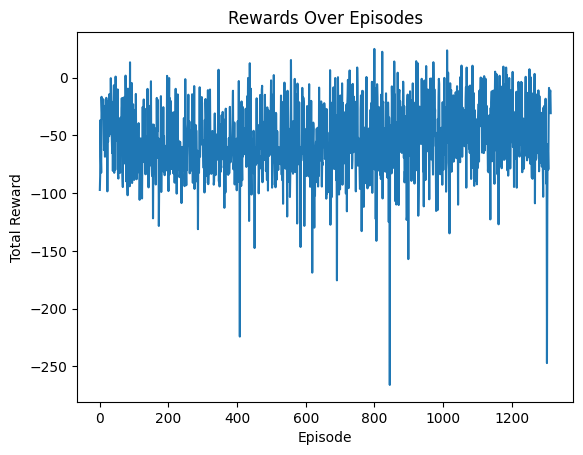

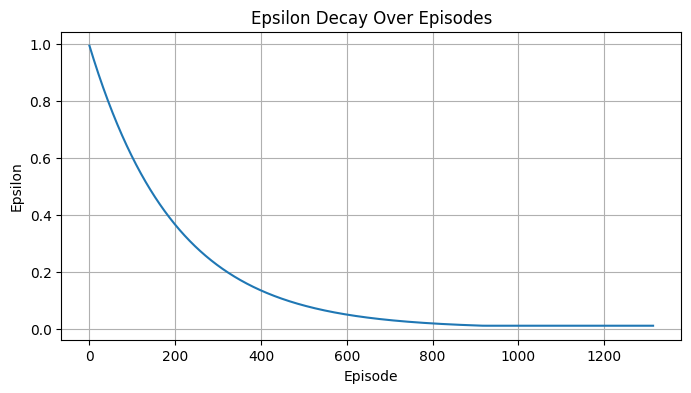

🎥 Displaying training video...


KeyboardInterrupt: 

In [6]:
import torch
import random
import numpy as np
import gym
import cv2
import imageio
import matplotlib.pyplot as plt
import os
import sys

# Hyperparameters
num_episodes = 1500
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.99
batch_size = 32
learning_rate = 0.0001
replay_buffer_size = 100000
update_frequency = 5
frame_capture_interval = 5

np.bool8 = np.bool_

# Environment and device
env = gym.make("LunarLander-v2", render_mode="rgb_array")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and replay buffer setup
main_dqn = DQN().to(device)
target_dqn = DQN().to(device)
optimizer = torch.optim.Adam(main_dqn.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
replay_buffer = []

# Paths and history
video_frames = []
video_save_path = "training_run.mp4"
model_save_path = "dqn_lunarlander.pth"
graph_save_path = "reward_plot.png"
rewards_history = []
epsilon_history = []

try:
    for episode in range(num_episodes):
        obs, _ = env.reset()
        frame = env.render()
        if frame is not None:
            state, stacked_frames = stack_frames(None, frame, True)
            video_frames.append(frame)
        else:
            print(f"Warning: Frame not captured at the start of episode {episode}")
            continue

        total_reward = 0
        done = False
        step_count = 0

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = main_dqn(state_tensor).argmax().item()

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            frame = env.render()
            step_count += 1

            if frame is not None and step_count % frame_capture_interval == 0:
                next_state, stacked_frames = stack_frames(stacked_frames, frame, False)
                video_frames.append(frame)
            else:
                next_state, stacked_frames = stack_frames(stacked_frames, frame, False)

            reward = np.clip(reward, -1, 1)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards_, next_states, dones = map(torch.tensor, zip(*batch))

                states = states.float().to(device)
                next_states = next_states.float().to(device)
                actions = actions.long().to(device)
                rewards_ = rewards_.float().to(device)
                dones = dones.float().to(device)

                with torch.no_grad():
                    next_actions = main_dqn(next_states).argmax(dim=1, keepdim=True)
                    next_q = target_dqn(next_states).gather(1, next_actions).squeeze(1)
                    target_q = rewards_ + gamma * next_q * (1 - dones)

                current_q = main_dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = criterion(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % update_frequency == 0:
            target_dqn.load_state_dict(main_dqn.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_history.append(total_reward)
        epsilon_history.append(epsilon)  # ✅ This was missing before!
        avg_reward = np.mean(rewards_history[-50:])
        print(f"Episode {episode} - Reward: {total_reward:.2f}, Epsilon: {epsilon:.4f}, Avg(50): {avg_reward:.2f}")

except Exception as e:
    print(f"⚠️ Training interrupted: {e}", file=sys.stderr)
    torch.save(main_dqn.state_dict(), "dqn_crash_backup.pth")
    imageio.mimsave("video_on_crash.mp4", video_frames, fps=30)
    raise

finally:
    # Save final model and video
    torch.save(main_dqn.state_dict(), model_save_path)
    imageio.mimsave(video_save_path, video_frames, fps=30)

    # Plot and save rewards
    plt.figure()
    plt.plot(rewards_history)
    plt.title("Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig(graph_save_path)
    plt.show()

    # Plot epsilon decay
    plt.figure(figsize=(8, 4))
    plt.plot(epsilon_history)
    plt.title("Epsilon Decay Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.grid(True)
    plt.show()

    # Display video after training
    print("🎥 Displaying training video...")
    cap = cv2.VideoCapture(video_save_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            cv2.imshow('Training Video', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()


In [7]:
# Save model
import torch
torch.save(main_dqn.state_dict(), "dqn_lunarlander.pth")


In [8]:
# Load model
main_dqn.load_state_dict(torch.load("dqn_lunarlander.pth"))
main_dqn.eval()


C:\Users\OMEN\AppData\Local\Temp\ipykernel_20612\3597416301.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  main_dqn.load_state_dict(torch.load("dqn_lunarlander.pth"))


DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [10]:
import gym
from gym.wrappers import RecordVideo
import numpy as np
from collections import deque
import torch
import cv2
def stack_frames(stacked_frames, new_frame, is_new_episode):
    if is_new_episode:
        stacked_frames = deque([np.zeros_like(new_frame) for _ in range(4)], maxlen=4)
    stacked_frames.append(new_frame)
    return np.stack(stacked_frames, axis=0), stacked_frames

# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Wrap with RecordVideo - records every episode
video_env = RecordVideo(env, "videos", episode_trigger=lambda x: True)

# Initialize
stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for _ in range(4)], maxlen=4)
obs = video_env.reset()

# Get initial frame (need to use env.render() before first step)
frame = env.render()  # Note: using the base env here, not video_env
frame = cv2.resize(frame, (84, 84))  # Resize to 84x84
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
frame = frame.astype(np.float32) / 255.0  # Normalize

state, stacked_frames = stack_frames(stacked_frames, frame, True)
done = False

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    q_values = main_dqn(state_tensor)
    action = q_values.argmax().item()
    
    next_obs, _, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated
    
    # Get next frame from base environment
    frame = env.render()
    frame = cv2.resize(frame, (84, 84))
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame.astype(np.float32) / 255.0
    
    state, stacked_frames = stack_frames(stacked_frames, frame, False)

video_env.close()

MoviePy - Building video C:\Users\OMEN\Downloads\videos\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\OMEN\Downloads\videos\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\OMEN\Downloads\videos\rl-video-episode-0.mp4


In [11]:
import os
import glob
import base64
from IPython.display import HTML



# Find the latest video file
video_path = glob.glob('./videos/**/*.mp4', recursive=True)[0]

# Display the video
def show_video(video_path):
    with open(video_path, "rb") as f:
        video_data = f.read()
    encoded_video = base64.b64encode(video_data).decode("utf-8")
    return HTML(f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{encoded_video}" type="video/mp4">
    </video>
    """)

show_video(video_path)
